Import packages and define some variables

In [327]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE=42

Define a small utility function

In [295]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# Data preprocessing

In [328]:
data = pd.read_csv("data/data_untreated.csv", index_col=0)
data.head()

,year,country,cgd,cpi,gdp,unemployment,suicides,population
0,1995,Albania,35.288883,40.762778,99602.052864,16.900000,88.0,2903400.0
1,1995,Antigua and Barbuda,NaN,NaN,26247.765147,NaN,0.0,66846.0
2,1995,Argentina,NaN,NaN,13339.409635,18.799999,2204.0,31345400.0
3,1995,Armenia,NaN,44.286056,193776.500640,24.000000,130.0,3443200.0
4,1995,Aruba,NaN,62.495164,34337.947862,NaN,8.0,73581.0


In [329]:
data.describe()

,year,cgd,cpi,gdp,unemployment,suicides,population
count,1654.000000,681.000000,1479.000000,1.644000e+03,1577.000000,1654.000000,1.654000e+03
mean,2004.596735,56.676592,82.994576,7.143152e+05,8.794356,2929.029625,2.229644e+07
std,5.681506,36.814464,23.962311,2.804038e+06,5.541547,7170.830242,4.196167e+07
min,1995.000000,3.675330,1.627491,4.364325e+02,0.300000,0.000000,2.380100e+04
25%,2000.000000,30.306790,71.519895,1.146569e+04,5.100000,139.000000,2.044640e+06
50%,2005.000000,49.776964,86.109598,3.455280e+04,7.600000,589.500000,5.547578e+06
75%,2009.000000,75.539374,100.000000,1.379862e+05,11.000000,2240.250000,2.087673e+07
max,2014.000000,195.992700,250.829327,2.829092e+07,37.299999,60548.000000,2.977497e+08


### Correlations

Checking correlations between all attributes

In [331]:
corr_matrix = data.corr()
corr_matrix["suicides"].sort_values(ascending=False)

suicides        1.000000
population      0.797822
gdp             0.135811
cgd             0.072343
year           -0.019156
cpi            -0.056288
unemployment   -0.090462
Name: suicides, dtype: float64

Checking linear relationship between unemployment rates and percentage of population who committed suicide

array([[<AxesSubplot:xlabel='unemployment', ylabel='unemployment'>,
        <AxesSubplot:xlabel='suicides', ylabel='unemployment'>],
       [<AxesSubplot:xlabel='unemployment', ylabel='suicides'>,
        <AxesSubplot:xlabel='suicides', ylabel='suicides'>]], dtype=object)

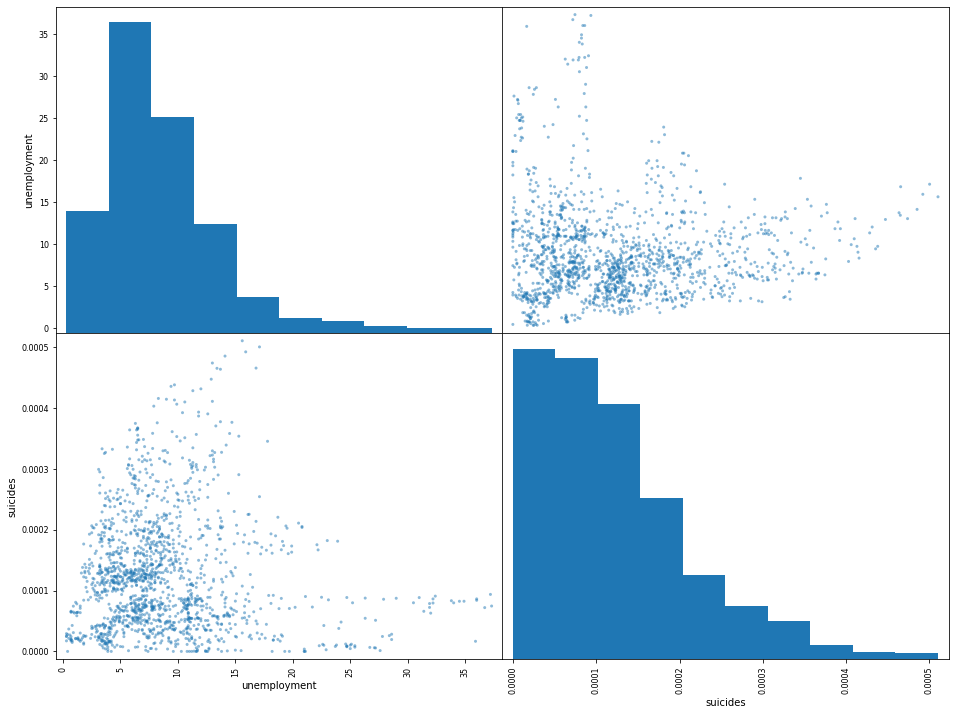

In [334]:
unemployment_data = data.copy()
unemployment_data['suicides'] = unemployment_data['suicides'] / unemployment_data['population']
pd.plotting.scatter_matrix(unemployment_data[['unemployment', 'suicides']], figsize=(16, 12))

### Split dataset

In [335]:
train_set, test_set = train_test_split(data, test_size=0.3, random_state=RANDOM_STATE)
train_set.head()

,year,country,cgd,cpi,gdp,unemployment,suicides,population
1288,2010,Malta,82.941687,100.000000,1.304903e+04,6.9,31.0,394949.0
18,1995,Croatia,NaN,60.265283,4.659630e+04,10.1,929.0,4497400.0
423,2000,Greece,119.226013,72.201294,1.744253e+04,11.1,382.0,10403059.0
1103,2008,Guyana,NaN,95.182964,4.259307e+05,11.8,168.0,669253.0
285,1998,Republic of Korea,NaN,70.907303,1.471583e+07,7.0,8569.0,43395700.0


### Preprocess entire dataset using scikit pipeline

In [354]:
num_vars = list(train_X)
num_vars.remove('country')

cat_vars = ['country']

In [359]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_vars),
    ("cat", LabelEncoder(), cat_vars)
])

In [360]:
train_X = train_set.drop("suicides", axis=1)
train_Y = train_set["suicides"].copy()

In [361]:
train_X.head()

,year,country,cgd,cpi,gdp,unemployment,population
1288,2010,Malta,82.941687,100.000000,1.304903e+04,6.9,394949.0
18,1995,Croatia,NaN,60.265283,4.659630e+04,10.1,4497400.0
423,2000,Greece,119.226013,72.201294,1.744253e+04,11.1,10403059.0
1103,2008,Guyana,NaN,95.182964,4.259307e+05,11.8,669253.0
285,1998,Republic of Korea,NaN,70.907303,1.471583e+07,7.0,43395700.0


In [358]:
train_X_prepared = full_pipeline.fit_transform(train_X)

TypeError: fit_transform() takes 2 positional arguments but 3 were given

# Model building

Experimenting with a couple of different models and comparing results.

### 1. Linear regression

In [304]:
lin_reg = LinearRegression()
lin_reg.fit(train_X_prepared, train_Y)

LinearRegression()

In [305]:
predictions_Y = lin_reg.predict(train_X_prepared)
lin_rmse = np.sqrt(mean_squared_error(predictions_Y, train_Y))
lin_rmse

1165.0863011053457

In [306]:
scores = cross_val_score(lin_reg, train_X_prepared, train_Y, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)

In [307]:
display_scores(lin_rmse_scores)

Scores: [1.42994442e+03 8.11477479e+02 3.48926395e+13 8.12658292e+02
 1.38512504e+03 2.33146388e+03 9.97355879e+02 6.91911172e+02
 1.57610066e+03 1.23027010e+03]
Mean: 3489263950857.578
Standard deviation: 10467791848817.297


Cross validation does not seem to improve the model significantly.

Let's try another model.

In [140]:
# LATER
# Create a row with values at will to predict
print('Original DataFrame\n------------------')
print(train_set)

new_row = {'country':'Portugal', 'year':2021, 'CPI':... , 'algebra':97}

# Create new empty dataset from previous data
# TODO
mock = ...

# Append row to dataset
mock = mock.append(new_row, ignore_index=True)

mock.head()

Original DataFrame
------------------
      year            country        cgd         cpi           gdp  \
1301  2010        Puerto Rico        NaN         NaN  2.689763e+03   
306   1998            Uruguay        NaN   39.272204  1.330253e+05   
192   1997             Kuwait        NaN   66.616642  1.170453e+04   
309   1999            Albania        NaN   74.116585  1.229235e+05   
1168  2009             Canada  51.294155   98.254150  4.783084e+04   
...    ...                ...        ...         ...           ...   
1130  2008  Republic of Korea        NaN   94.523000  2.410220e+07   
1294  2010             Norway  35.137789  100.000000  5.297516e+05   
860   2005         Luxembourg   3.675330   89.692132  7.521767e+04   
1459  2012              Malta  85.935505  105.205335  1.321949e+04   
1126  2008             Poland        NaN   93.776067  3.056181e+04   

      unemployment  suicides_over_population  
1301     16.200001                  0.000082  
306       8.800000         

AttributeError: 'ellipsis' object has no attribute 'append'